<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/eda_nytimes-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining NYTimes data with county census and geoson data

In [6]:
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

import seaborn as sns
import altair as alt
from altair import datum

from scipy.signal import savgol_filter

from urllib.request import urlopen
import json

from time import time
from datetime import datetime, timedelta
from pytz import timezone

import matplotlib.pyplot as plt

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [7]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [8]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [9]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395636 entries, 0 to 395635
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    395636 non-null  datetime64[ns]
 1   county  395636 non-null  category      
 2   state   395636 non-null  category      
 3   fips    391671 non-null  category      
 4   cases   395636 non-null  int32         
 5   deaths  395636 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 7.4 MB


# import census and GeoJSON data

We want to calculate ratios comparing the number of cases (or deaths) to the population and/or area of the county. Since the population density varies wildly per county, relying on just the absolute number of reported cases could be misleading.

In [10]:
with open('data/county_json_ac.json') as f:
    county_json_ac = json.load(f)

In [11]:
pop_df_ac = optimize(pd.read_csv('data/pop_df_ac.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(pop_df_ac.shape)
pop_df_ac.head()

(579, 48)


,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area,...,per_some_hs,per_hs,per_some_college,per_associates,per_bachelors,per_graduate,edu,mask,per_gop,gop
0,Alabama,0,Bibb-Chilton-Colbert-Fayette-Franklin-Lamar-La...,635399,01007-01021-01033-01057-01059-01075-01077-0107...,481116,107655,5334,27253,8600.974609,...,0.104216,0.358440,0.207511,0.074634,0.124811,0.076889,2.827550,2.979335,0.735876,1
1,Alabama,1,Barbour-Bullock-Coffee-Covington-Crenshaw-Dale...,445623,01005-01011-01031-01039-01041-01045-01061-0106...,275462,133705,4396,20334,8025.200195,...,0.118384,0.328613,0.226480,0.090919,0.115534,0.067272,2.800026,2.854823,0.674085,1
2,Alabama,2,Autauga-Elmore-Lee-Montgomery-Shelby,745808,01001-01051-01081-01101-01117,454080,227227,20222,31304,3389.634033,...,0.077775,0.250683,0.217038,0.078086,0.211599,0.130933,3.386192,3.105748,0.615056,1
3,Alabama,3,Blount-Calhoun-Cullman-DeKalb-Etowah-Jackson-L...,885486,01009-01015-01043-01049-01055-01071-01083-0109...,709226,84059,6814,63608,6712.454102,...,0.112248,0.330849,0.225502,0.089564,0.114511,0.063755,2.763798,2.886709,0.808339,1
4,Alabama,4,Choctaw-Clarke-Greene-Hale-Marengo-Pickens-Sum...,126519,01023-01025-01063-01065-01091-01107-01119-01129,59408,60860,722,2771,7285.401855,...,0.126806,0.402477,0.195001,0.080391,0.085501,0.052709,2.582081,3.140058,0.494306,0


In [12]:
pop_df_ac.sort_values(by='total_pop').iloc[[0, -1]]

,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area,...,per_some_hs,per_hs,per_some_college,per_associates,per_bachelors,per_graduate,edu,mask,per_gop,gop
508,Texas,27,Loving,169,48301,137,6,2,23,668.924988,...,0.226667,0.200000,0.386667,0.186667,0.000000,0.000000,2.533333,3.044,0.934426,1
48,California,18,Los Angeles,10039107,06037,2615947,798279,1485197,4881970,4057.884033,...,0.087326,0.206922,0.192031,0.069574,0.206975,0.111115,3.057121,3.648,0.246727,0


In [13]:
pop_df_ac.sort_values(by='pop_density').iloc[[0, -1]]

,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area,...,per_some_hs,per_hs,per_some_college,per_associates,per_bachelors,per_graduate,edu,mask,per_gop,gop
508,Texas,27,Loving,169,48301,137,6,2,23,668.924988,...,0.226667,0.20000,0.386667,0.186667,0.000000,0.000000,2.533333,3.044,0.934426,1
348,New York,11,New York,1628706,36061,769099,201829,204096,416759,22.829000,...,0.060077,0.12433,0.097738,0.039753,0.313722,0.294363,4.095749,3.671,0.102600,0


There are several things to consider:

- Raw numbers will show New York City and Los Angeles County with the highest numbers, all other factors being equal.
- Reporting cases as a percentage (or as we'll use later, a per 100k) would better reflect the severity of infections.
- However, a higher population density would likely make it easier to transmit the disease to another person. Looking at the day-to-day change in new cases could allow us to see how quickly the disease is spreading.

The NYTimes dataset does not include diacritical marks for the names of Puerto Rico's municipios. In the interest of cultural accuracy, we will preserve them when merging with `pop_df`. 

The NYTimes dataset deals with New York City, Kansas City, and Joplin as their own entities. As such, they do not have valid `fips` codes; we must add our custom `fips` from our earlier census EDA.

In [14]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = '36NYC'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = '29KCM'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = '29JOP'
nyt_df['fips'] = nyt_df['fips'].astype('category')

In [15]:
nyt_df[nyt_df['fips']=='36NYC']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,36NYC,1,0
448,2020-03-02,New York City,New York,36NYC,1,0
482,2020-03-03,New York City,New York,36NYC,2,0
518,2020-03-04,New York City,New York,36NYC,2,0
565,2020-03-05,New York City,New York,36NYC,4,0
...,...,...,...,...,...,...
381401,2020-07-29,New York City,New York,36NYC,229237,22982
384619,2020-07-30,New York City,New York,36NYC,229551,22996
387836,2020-07-31,New York City,New York,36NYC,229834,23002
391053,2020-08-01,New York City,New York,36NYC,230147,23007


In [16]:
nyt_df.to_csv('data/nyt_df.csv', index=False)

# merge `nyt_df` and `pop_df` for feature engineering

In [17]:
pop_df = optimize(pd.read_csv('data/pop_df.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(pop_df.shape)
pop_df.head()

(3145, 46)


,state,county,total_pop,fips,white,black,asian,hispanic,area,lon,...,per_no_hs,per_some_hs,per_hs,per_associates,per_bachelors,per_graduate,per_college,per_gop,gop,cluster
0,Alabama,Autauga,55869,01001,41215,11098,646,1671,594.435974,-86.641197,...,0.025722,0.087392,0.326078,0.080665,0.158828,0.118065,0.357558,0.754018,True,2
1,Alabama,Baldwin,223234,01003,185747,19215,2346,10534,1589.784058,-87.723953,...,0.027063,0.070291,0.276068,0.093606,0.207029,0.106430,0.407064,0.798123,True,5
2,Alabama,Barbour,24686,01005,11235,11807,116,1117,884.875977,-85.389244,...,0.081990,0.187696,0.356903,0.070379,0.077973,0.044186,0.192538,0.528359,True,1
3,Alabama,Bibb,22394,01007,16663,4719,46,623,622.581970,-87.124962,...,0.057224,0.110710,0.473447,0.057541,0.075856,0.039037,0.172433,0.782270,True,0
4,Alabama,Blount,57826,01009,50176,872,163,5582,644.776001,-86.569756,...,0.074873,0.123502,0.340399,0.120499,0.081182,0.045247,0.246928,0.913855,True,3


To reduce the size of the resulting `csv`, we will only merge with the `tot_pop` column to engineer our per capita columns. We can merge with `pop_df` again when plotting our data.

In [18]:
df = nyt_df.merge(
    pop_df[['fips', 'cluster', 'state', 'county']], 
    on='fips', 
    suffixes=('_x','')
)

df = df.drop(['county_x', 'state_x'], axis=1)
df = df.sort_values(by=['date', 'fips'])
print(df.shape)
df.head()

(384485, 7)


,date,fips,cases,deaths,cluster,state,county
0,2020-01-21,53061,1,0,0,Washington,Snohomish
1,2020-01-22,53061,1,0,0,Washington,Snohomish
2,2020-01-23,53061,1,0,0,Washington,Snohomish
195,2020-01-24,17031,1,0,11,Illinois,Cook
3,2020-01-24,53061,1,0,0,Washington,Snohomish


In [19]:
df_clustered = df.groupby(by=['state', 'cluster', 'date']).agg(
    cases=('cases', sum),
    deaths=('deaths', sum)
).dropna().reset_index().astype({'cases': 'int', 'deaths':'int'})

df_clustered.head()

,state,cluster,date,cases,deaths
0,Alabama,0,2020-03-13,1,0
1,Alabama,0,2020-03-14,2,0
2,Alabama,0,2020-03-15,3,0
3,Alabama,0,2020-03-16,3,0
4,Alabama,0,2020-03-17,3,0


In [21]:
df = df_clustered.merge(pop_df_ac, on=['state', 'cluster'], suffixes=('_x',''))
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['total_pop'], axis=0) * 100_000
df = df.sort_values(by=['date', 'fips'])

print(df.shape)
df.head()

(80332, 53)


,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,per_some_college,per_associates,per_bachelors,per_graduate,edu,mask,per_gop,gop,cases_per_100k,deaths_per_100k
75800,Washington,0,2020-01-21,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.264304,0.109831,0.200486,0.103499,3.399019,3.465292,0.433872,0,0.042119,0.0
75801,Washington,0,2020-01-22,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.264304,0.109831,0.200486,0.103499,3.399019,3.465292,0.433872,0,0.042119,0.0
75802,Washington,0,2020-01-23,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.264304,0.109831,0.200486,0.103499,3.399019,3.465292,0.433872,0,0.042119,0.0
24946,Illinois,11,2020-01-24,1,0,Cook,5150233,17031,2162156,1184247,...,0.188318,0.065391,0.226144,0.153550,3.411196,3.539000,0.223595,0,0.019417,0.0
75803,Washington,0,2020-01-24,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.264304,0.109831,0.200486,0.103499,3.399019,3.465292,0.433872,0,0.042119,0.0


In [22]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    return (df, cols_d)

In [23]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7sg = add_savgol_cols(df, new_cols)
df, new_cols_15sg = add_savgol_cols(df, new_cols, window=15)
df, delta_new_cols = add_change_cols(df, new_cols, pre='delta_', clip=False)
df, delta_new_cols_7sg = add_savgol_cols(df, delta_new_cols)
df, delta_new_cols_15sg = add_savgol_cols(df, delta_new_cols, window=15)

print(df.columns)
df.head()

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area', 'lon', 'lat',
       'votes_gop', 'votes_dem', 'total_votes', 'median_income', 'pop25',
       'no_hs', 'some_hs', 'hs', 'some_college', 'associates', 'bachelors',
       'graduate', 'never', 'rarely', 'sometimes', 'frequently', 'always',
       'pop_density', 'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'per_no_hs',
       'per_some_hs', 'per_hs', 'per_some_college', 'per_associates',
       'per_bachelors', 'per_graduate', 'edu', 'mask', 'per_gop', 'gop',
       'cases_per_100k', 'deaths_per_100k', 'new_cases', 'new_deaths',
       'new_cases_per_100k', 'new_deaths_per_100k', 'new_cases_7sg',
       'new_deaths_7sg', 'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg',
       'new_cases_15sg', 'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delt

,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg
75800,Washington,0,2020-01-21,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
75801,Washington,0,2020-01-22,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
75802,Washington,0,2020-01-23,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
24946,Illinois,11,2020-01-24,1,0,Cook,5150233,17031,2162156,1184247,...,0.0,0.0,-0.178571,0.0,-0.003467,0.0,0.025,0.0,0.000485,0.0
75803,Washington,0,2020-01-24,1,0,Island-Kitsap-Pierce-Snohomish-Thurston,2374213,53029-53035-53053-53061-53067,1642511,112823,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0


In [24]:
df.to_csv('data/df.csv', index=False)

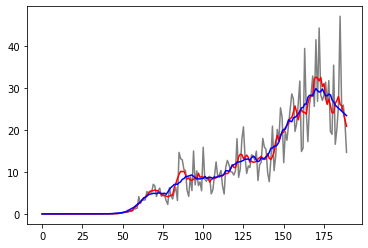

In [25]:
county = 'Los Angeles'
temp_df = df[df['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')

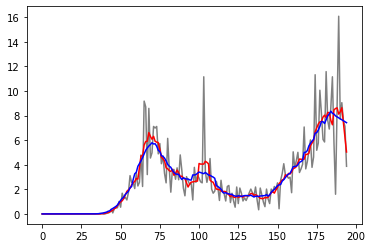

In [27]:
county = 'Island-Kitsap-Pierce-Snohomish-Thurston'
temp_df = df[df['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')